In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import string


import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from keras.models import Sequential


from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM

2023-09-04 19:05:13.752760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/frankzhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data Preprocessing

In [2]:
#used for parsing out data
parse = string.punctuation + "1234567890\n"
colNames = ["text", "class"]

pos = pd.DataFrame(columns = colNames)
neg = pd.DataFrame(columns = colNames)

#positive data
pos_files = sorted(glob.glob(os.path.join("../data/pos/", "*.txt")))
posCount = 0
for i in pos_files:
    fp = open(i, "r")
    data = fp.read()
    fp.close()
    data = data.translate(str.maketrans('','', parse))
    pos.loc[posCount] = [data, 1]
    posCount += 1

#negative data
neg_files = sorted(glob.glob(os.path.join("../data/neg/", "*.txt")))
negCount = 0
for i in neg_files:
    fp = open(i, "r")
    data = fp.read()
    fp.close()
    data = data.translate(str.maketrans('','', parse))
    neg.loc[negCount] = [data, 0]#0 used because of sigmoid [0, 1]
    negCount += 1

Splitting Test and Train Data

In [3]:
#splitting train and test data 7:3
data = pd.concat([pos, neg])
train = pd.concat([pos.iloc[:700,:], neg.iloc[:700,:]])
test = pd.concat([pos.iloc[700:,:], neg.iloc[700:,:]])
trainLabel = pd.concat([pos.iloc[:700,1:], neg.iloc[:700,1:]])
testLabel = pd.concat([pos.iloc[700:,1:], neg.iloc[700:,1:]])

Data Stats

Total num of unique words: 46830
Average Review Length: 748.292
Standard deviation: 328.70987015299676


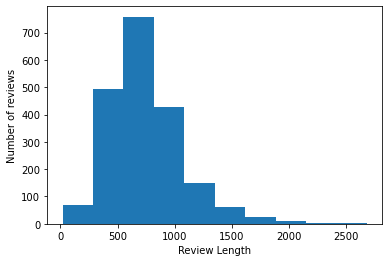

In [4]:
unique = set()
dataList = []
for i in range(0, 2000):
    words = data.iloc[i,0].split(" ")
    line = ""
    for j in words:
        if j != "":
            unique.add(j)
            line += (j + " ")
    dataList.append(line)
print("Total num of unique words:", len(unique))

total = []
for i in range(0, 2000):
    total.append(len(data.iloc[i,0].split(" ")))
nptotal = np.asarray(total)
print("Average Review Length:", np.mean(nptotal))
print("Standard deviation:", np.std(nptotal))

plt.hist(nptotal)
plt.xlabel('Review Length')
plt.ylabel('Number of reviews')
plt.show()

Selecting a review length for padding and truncating:

In [5]:
dataLengths = []

trainWords = [] #for tokenization
for i in range(0, len(train)):
    dataLengths.append(len(train.iloc[i,0].split(" ")))
    words = train.iloc[i,0].split(" ")
    line = ""
    for j in words:
        if j != "":
            unique.add(j)
            line += (j + " ")
    trainWords.append(line)

testWords = [] #for tokenization
for i in range(0, len(test.index)):
    dataLengths.append(len(test.iloc[i,0].split(" ")))
    words = test.iloc[i,0].split(" ")
    line = ""
    for j in words:
        if j != "":
            unique.add(j)
            line += (j + " ")
    testWords.append(line)
testLabel = test["class"]

dataLengths = sorted(dataLengths)
maxLength = dataLengths[int(.7 * len(dataLengths))]
print(maxLength)


852


In [6]:
#Tokenize the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataList)
wordIndex = tokenizer.word_index
trainSequences = tokenizer.texts_to_sequences(trainWords)
testSequences = tokenizer.texts_to_sequences(testWords)

#padding and truncating
trainPadded = pad_sequences(trainSequences, maxlen = maxLength, padding='post', truncating='post')
testPadded = pad_sequences(testSequences, maxlen = maxLength, padding='post', truncating='post')

#only interested in the top 5000 words
trainPadded[trainPadded >= 5000] = 0
testPadded[testPadded >= 5000] = 0

Model 1: Multi-Layer Perceptron

In [7]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=maxLength))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dropout(.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(.5))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainPadded, trainLabel, epochs=2, batch_size=10)
loss, accuracy = model.evaluate(trainPadded, trainLabel, verbose=0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model.evaluate(testPadded, testLabel, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

2023-09-04 19:05:22.767027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2
140/140 [==============================] - 3s 16ms/step - loss: 0.6967 - accuracy: 0.5207
Epoch 2/2
140/140 [==============================] - 2s 17ms/step - loss: 0.6576 - accuracy: 0.6143
Train Accuracy: 91.214287
Test Accuracy: 61.833334


Model 2: One Dimensional Convolutional Neural Netword

In [8]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=maxLength))
model.add(Conv1D(filters = 32, kernel_size = 3, groups = 32))
model.add(MaxPooling1D(strides = 2))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dropout(.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(.5))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainPadded, trainLabel, epochs=2, batch_size=10)
loss, accuracy = model.evaluate(trainPadded, trainLabel, verbose=0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model.evaluate(testPadded, testLabel, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

Epoch 1/2
  2/140 [..............................] - ETA: 9s - loss: 0.6937 - accuracy: 0.5000  

2023-09-04 19:05:30.337831: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7ade6acf50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-04 19:05:30.337871: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-09-04 19:05:30.338157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 19:05:30.355347: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 [==============================] - 10s 62ms/step - loss: 0.6967 - accuracy: 0.4979
Epoch 2/2
140/140 [==============================] - 9s 62ms/step - loss: 0.6935 - accuracy: 0.5179
Train Accuracy: 62.214285
Test Accuracy: 48.500001


Model 3: Long Short-Term Memory Recurrent Neural Network

In [9]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=maxLength))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(.2))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(trainPadded, trainLabel, epochs=50, batch_size=10)
loss, accuracy = model.evaluate(trainPadded, trainLabel, verbose=0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model.evaluate(testPadded, testLabel, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

Epoch 1/50
140/140 [==============================] - 18s 117ms/step - loss: 0.6925 - accuracy: 0.5221
Epoch 2/50
140/140 [==============================] - 28s 200ms/step - loss: 0.6866 - accuracy: 0.5393
Epoch 3/50
140/140 [==============================] - 64s 460ms/step - loss: 0.6396 - accuracy: 0.5871
Epoch 4/50
140/140 [==============================] - 64s 459ms/step - loss: 0.6127 - accuracy: 0.6136
Epoch 5/50
140/140 [==============================] - 75s 537ms/step - loss: 0.5951 - accuracy: 0.6150
Epoch 6/50
140/140 [==============================] - 62s 446ms/step - loss: 0.5680 - accuracy: 0.6050
Epoch 7/50
140/140 [==============================] - 38s 267ms/step - loss: 0.5598 - accuracy: 0.6107
Epoch 8/50
140/140 [==============================] - 22s 157ms/step - loss: 0.5701 - accuracy: 0.6014
Epoch 9/50
140/140 [==============================] - 19s 137ms/step - loss: 0.5628 - accuracy: 0.6129
Epoch 10/50
140/140 [==============================] - 19s 132ms/step - l